In [1]:
import numpy as np
import pandas as pd
from dobbel import dobbellogger

In [24]:
dob = dobbellogger()
dob.log(10, 200, 8, 125)
dob.download()
data = dob.datadf

Logging data for 10s
Done! The data is located in self.datadf


In [25]:
def expq(vector, multiplier=1):
    x, y, z = vector[0] * multiplier, vector[1] * multiplier, vector[2]  * multiplier
    absq = (x ** 2 + y ** 2 + z ** 2) ** 1/2
    w = np.cos(absq)
    sinabs = np.sin(absq)
    xq = x * sinabs / absq
    yq = y * sinabs / absq
    zq = z * sinabs / absq
    return np.array([w, xq, yq, zq])

In [26]:
def quat_mul(p, q):
    p0 = p[0]
    q0 = q[0]
    pv = p[1:]
    qv = q[1:]
    out0 = p0 * q0 - np.dot(pv, qv)
    outv = p0 * qv + q0 * pv + np.cross(pv, qv)
    out = np.array([out0, *outv])
    return out

In [27]:
def quaternion_conjugate(q):
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

In [28]:
# Actual Rotation Fuction - Input = Acceleration vector = 1x3 , rotation_quaternion = 1*4
def rotate_vector(vector, rotation_quaternion):
    # Convert the vector to a quaternion
    vector_quaternion = np.concatenate(([0], vector))

    # Calculate the rotated quaternion
    rotated_quaternion = quat_mul(rotation_quaternion, quat_mul(vector_quaternion, quaternion_conjugate(rotation_quaternion)))

    # Extract the rotated vector from the quaternion
    rotated_vector = rotated_quaternion[1:]

    return np.array(rotated_vector)

In [29]:
def remove_nan(df):
    counter = 0
    nan = True
    while nan:
        if not df.loc[counter].isna().any():
            nan = False
        counter += 1
    for i in range(counter - 1):
        df = df.drop(index=i)
    df = df.reset_index(drop=True)
    counter = len(df) - 1
    nan = True
    while nan:
        if not df.loc[counter].isna().any():
            nan = False
        counter -= 1
    maxlen = len(df)
    for i in range(maxlen - 1, counter + 1, -1):
        df = df.drop(index=i)
    df = df.reset_index(drop=True)
    for i in range(len(df)):
        df['timestamp'][i] = df['timestamp'][i] - df['timestamp'][0]
    for i in range(len(df)):
        for column in df.columns:
            if np.isnan(df[column][i]):
                deler = (df['timestamp'][i] - df['timestamp'][i - 1]) / (df['timestamp'][i + 1] - df['timestamp'][i - 1])
                df[column][i] = df[column][i - 1] + deler * (df[column][i + 1] - df[column][i - 1])
    return df

In [30]:
data = remove_nan(data)
data.head(1000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,0.604004,-0.016602,0.777588,-0.285823,0.335366,-0.834604
1,21.0,0.604248,-0.014160,0.780029,0.072409,0.224848,-0.072409
2,25.0,0.603760,-0.013672,0.779053,-0.034299,0.379827,0.019055
3,27.0,0.604085,-0.013835,0.779297,-0.087652,0.457317,0.064787
4,31.0,0.604736,-0.014160,0.779785,-0.141006,0.537348,-0.049543
...,...,...,...,...,...,...,...
995,4804.0,0.597656,-0.015137,0.783447,-0.060976,0.461128,-0.003811
996,4808.0,0.595947,-0.017578,0.783447,-0.182927,0.476372,0.026677
997,4812.0,0.597412,-0.015869,0.783203,-0.007622,0.430640,-0.015244
998,4818.0,0.597900,-0.016846,0.789795,-0.125762,0.468750,0.026677


In [31]:
def detect_number(arr):
    x, y, z = arr
    print(x, y, z)
    if x < - 0.5 and np.abs(y) < 0.1 and z < -0.5:
        return 1
    elif np.abs(x) < 0.1 and y > 0.8 and np.abs(z) < 0.1:
        return 2
    elif x > 0.5 and np.abs(y) < 0.1 and z < -0.5:
        return 3
    elif x < 0.5 and np.abs(y) < 0.1 and z > -0.5:
        return 4
    elif np.abs(x) < 0.1 and y < -0.8 and np.abs(z) < 0.1:
        return 5
    elif x > 0.5 and np.abs(y) < 0.1 and z > 0.5:
        return 6
    else:
        return 'Could not detect number'

In [32]:
gravDetectTime = 100

gyro_bias = np.array([0, 0, 0])
acc_bias = np.array([0, 0, 0])
gyro_noise = np.array([0, 0, 0])
acc_noise_p = np.array([0, 0, 0])
acc_noise_v = np.array([0, 0, 0])

q = np.array([1, 0, 0, 0])
v = np.array([0, 0, 0])
p = np.array([0, 0, 0])
q_list = [q]
p_list = [p]
v_list = [v]


arr = np.array([data['x_acc'][:gravDetectTime], data['y_acc'][:gravDetectTime], data['z_acc'][:gravDetectTime]])
mean_grav = np.array([9.81 * sum(arr[0,:]) / len(arr[0, :]), 9.81 * sum(arr[1,:]) / len(arr[1, :]), 9.81 * sum(arr[2,:]) / len(arr[2, :])])

for i in range(gravDetectTime, len(data['timestamp']) - 1):
    dt = (data['timestamp'][i + 1] - data['timestamp'][i]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement - gyro_bias - gyro_noise
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)
    q = quat_mul(q, expq_omega)
    ab = np.array([data['x_acc'][i], data['y_acc'][i], data['z_acc'][i]])
    ab = 9.81 * ab
    an = rotate_vector(ab, q) - rotate_vector(mean_grav, q)
    anp = an - acc_bias - acc_noise_p
    anv = an - acc_bias - acc_noise_v
    p = p + dt * v + 0.5 * anp * dt ** 2 
    v = v + dt * anv
    q_list.append(q)
    p_list.append(p)
    v_list.append(v)
    
estimate = pd.DataFrame(columns=['timestamp', 'x_p', 'y_p', 'z_p'])
estimate['timestamp'] = data['timestamp'][gravDetectTime:]

p_array = np.array(p_list)
estimate['x_p'] = p_array[:, 0]
estimate['y_p'] = p_array[:, 1]
estimate['z_p'] = p_array[:, 2]

In [33]:
estimate.head(1000)

,timestamp,x_p,y_p,z_p
100,499.0,0.000000e+00,0.000000e+00,0.000000e+00
101,504.0,3.795433e-08,-3.283010e-07,-5.730679e-07
102,509.0,2.715685e-07,-1.492832e-06,-2.022837e-06
103,513.0,4.939573e-07,-2.772672e-06,-3.543232e-06
104,519.0,1.047981e-06,-4.086458e-06,-6.178971e-06
...,...,...,...,...
1095,5291.0,4.931292e-01,-6.786563e-02,-2.746223e-02
1096,5296.0,4.935545e-01,-6.803641e-02,-2.660110e-02
1097,5300.0,4.938962e-01,-6.816339e-02,-2.591316e-02
1098,5306.0,4.944088e-01,-6.835801e-02,-2.488467e-02


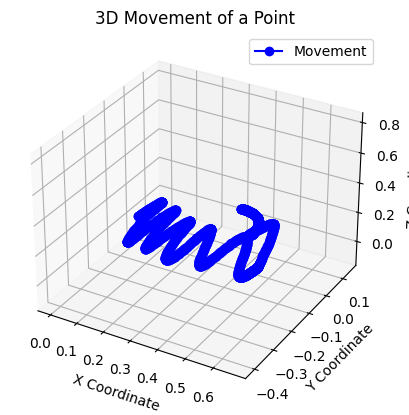

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data: Replace these with your actual lists of coordinates
x_positions = p_array[:, 0]
y_positions = p_array[:, 1]
z_positions = p_array[:, 2]

# Create a new figure for the 3D plot
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the movement of the point
ax.plot(x_positions, y_positions, z_positions, marker='o', linestyle='-', color='b', label='Movement')

# Set labels for each axis
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set a title
ax.set_title('3D Movement of a Point')

# Add a legend
ax.legend()

# Show the plot
plt.show()
